# Telecom Customer Churn Prediction Project
Author: Oun Nuqul 

October 4th 2025
## Executive Summary
This notebook implements a supervised machine learning solution to predict customer churn for a telecommunications company. We classify customers into binary categories (Churn vs No Churn) using customer demographics, service usage, and account information.

## Business Objective
- **Goal**: Predict customer churn to enable proactive retention strategies and reduce customer acquisition costs
- **Target Variable**: Binary classification of churn (Churn vs No Churn)
- **Features**: Customer demographics, service plans, usage patterns, and account information
- **Models**: Logistic Regression (baseline) and Gradient Boosting (optimized with Grid Search)

## Dataset Overview
The dataset contains telecom customer records with demographics, service subscriptions, billing information, and churn status.

## 1. Environment Setup

### Import Required Libraries
We import essential libraries for data manipulation, visualization, and machine learning:
- **pandas**: Data manipulation and analysis
- **numpy**: Numerical computations
- **matplotlib**: Data visualization
- **seaborn**: Statistical data visualization
- **sklearn**: Machine learning algorithms and evaluation metrics

In [141]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

## 2. Data Loading

### Load Dataset
Loading the telecom customer dataset from CSV file. This dataset contains customer information, service subscriptions, and churn indicators.

In [182]:
df = pd.read_csv('data.csv')

## 3. Initial Data Exploration

### Data Structure and Quality Assessment
Understanding the dataset structure, data types, and identifying any data quality issues such as missing values.

In [184]:
df.shape

(7043, 21)

In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [186]:
# Checking for NaN values
df.isna().sum().sum()

0

In [187]:
# Checking for completed duplicated rows
df.duplicated().sum()

0

In [190]:
#Checking for duplicated orders
df.duplicated(subset='customerID').sum()

0

In [192]:
# removing non meaningfull data
df = df.drop(columns=['customerID'])

In [206]:
df['TotalCharges'] = np.where(df['TotalCharges']==' ',0,df['TotalCharges'])
df['TotalCharges'] = df['TotalCharges'].astype('float')

## 4. Comprehensive Exploratory Data Analysis (EDA)

### 4.1 Dataset Overview and Quality Assessment
Comprehensive analysis of dataset structure, missing values, and basic statistics to understand customer behavior patterns and data quality.

### Quick Churn Distribution Visualization
Initial visualization of the target variable distribution to understand churn patterns in our customer base.

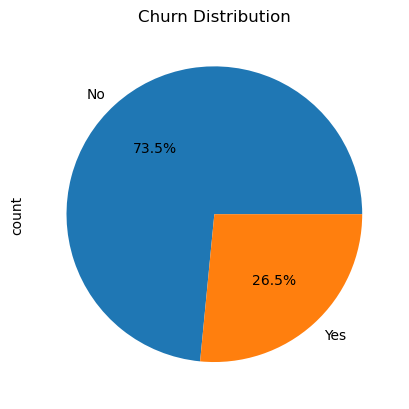

In [195]:
plt.figure()
df['Churn'].value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%')
plt.title('Churn Distribution')
plt.show()

### 4.2 Feature Distribution Analysis
Visualizing the distribution of key categorical variables to understand customer demographics, service preferences, and usage patterns. This helps identify factors that may influence churn and informs feature engineering decisions.

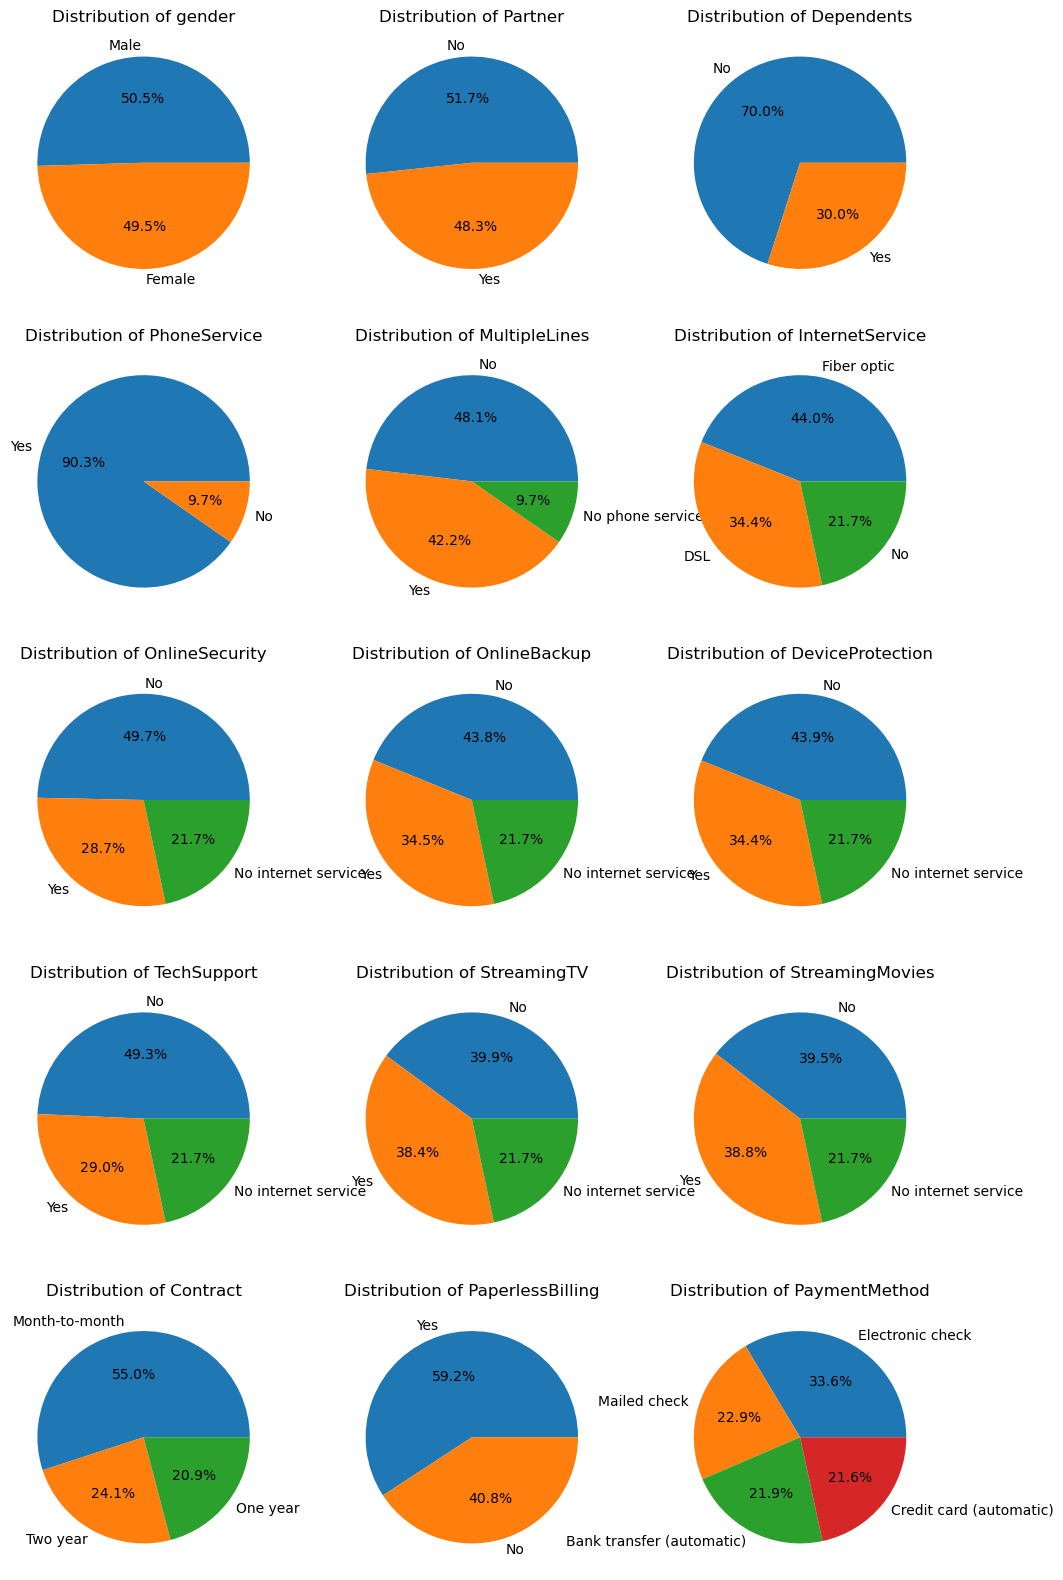

In [213]:
# Cateogical feature analysis
plt.subplots(5,3,figsize=(12,20))
for c, i in zip(df.drop(columns='Churn').select_dtypes(exclude=['number','float']).columns,range(1,18)):
    plt.subplot(5,3,i)
    df[c].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title(f'Distribution of {c}')
    plt.ylabel('')
plt.show()


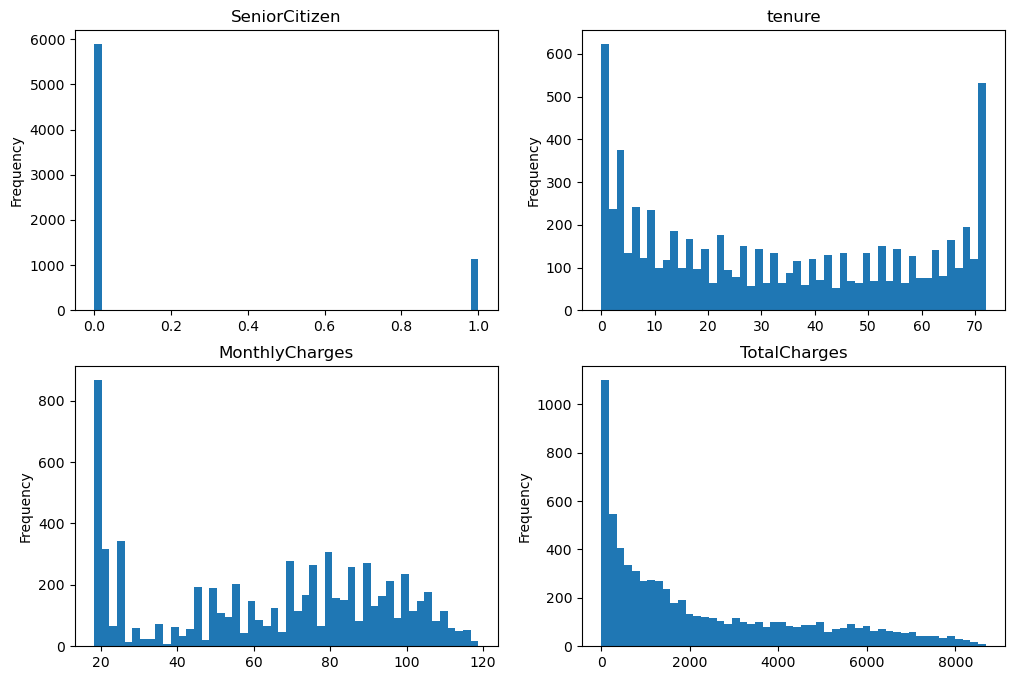

In [217]:
plt.subplots(2,2,figsize=(12,8))
for c, i in zip(df.select_dtypes('number').columns, range(1,5)):
    plt.subplot(2,2,i)
    df[c].plot(kind='hist',bins=50)
    plt.title(c)
    

### 4.3 Target Variable Relationship Analysis
Analyzing the relationship between customer features and churn behavior. This correlation analysis helps identify which factors are most predictive of customer churn and guides feature selection for modeling.

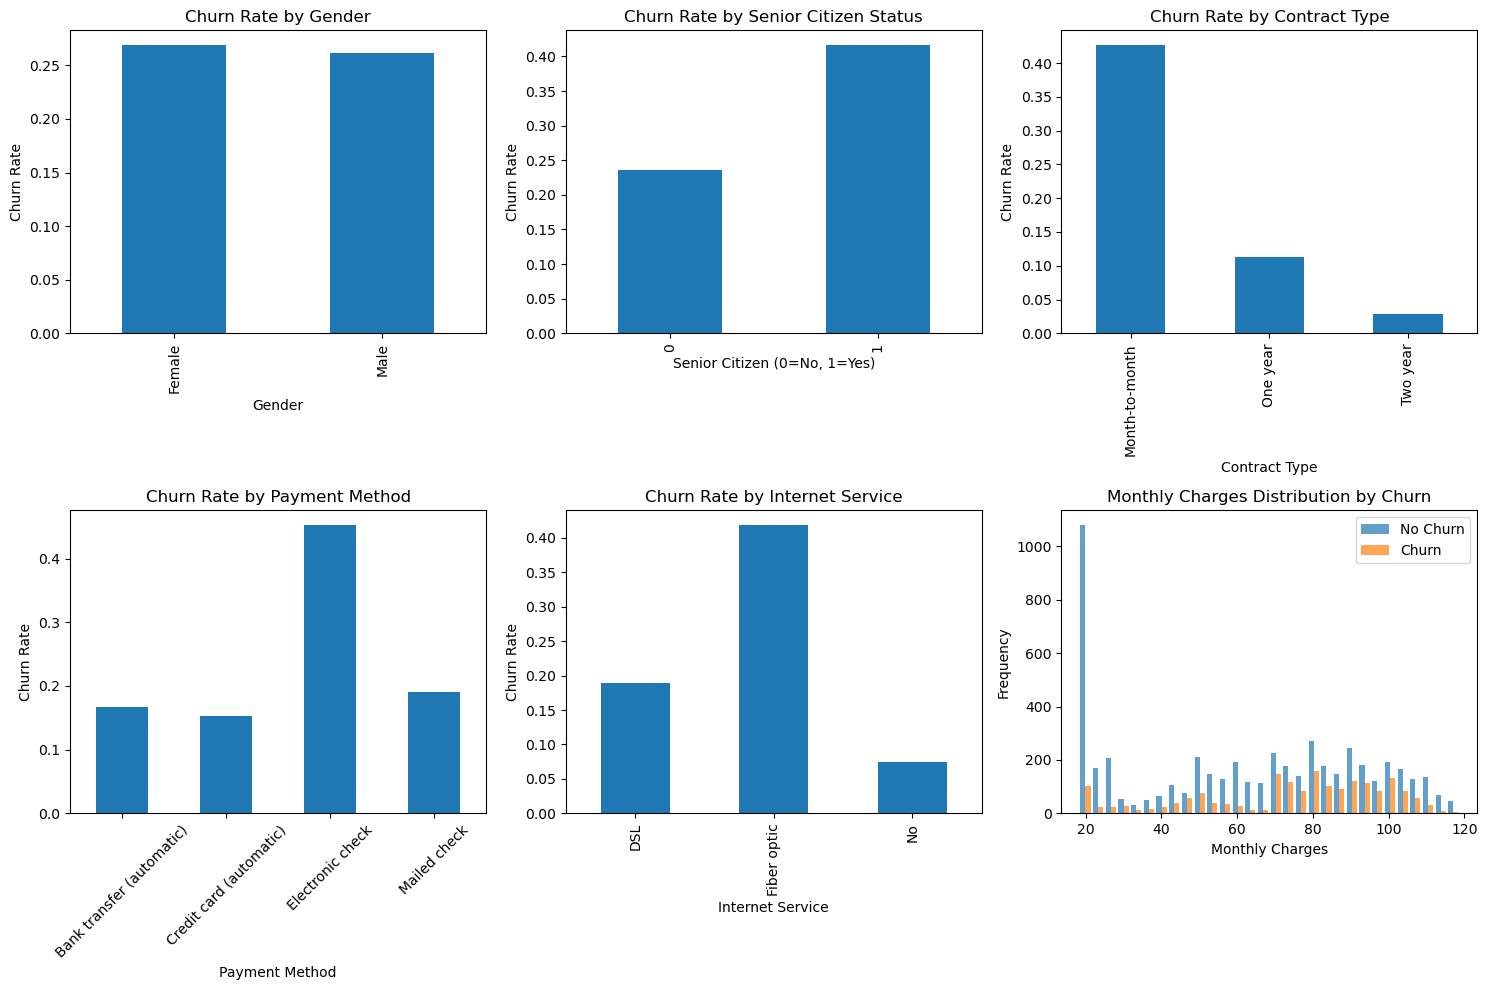

In [218]:
# Create binary target for churn analysis
df['Churn_Binary'] = np.where(df['Churn'] == 'Yes', 1, 0)

plt.figure(figsize=(15, 10))

# Churn by Gender
plt.subplot(2, 3, 1)
gender_churn = df.groupby('gender')['Churn_Binary'].mean()
gender_churn.plot(kind='bar')
plt.title('Churn Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Churn Rate')

# Churn by Senior Citizen Status
plt.subplot(2, 3, 2)
senior_churn = df.groupby('SeniorCitizen')['Churn_Binary'].mean()
senior_churn.plot(kind='bar')
plt.title('Churn Rate by Senior Citizen Status')
plt.xlabel('Senior Citizen (0=No, 1=Yes)')
plt.ylabel('Churn Rate')

# Churn by Contract Type
plt.subplot(2, 3, 3)
contract_churn = df.groupby('Contract')['Churn_Binary'].mean()
contract_churn.plot(kind='bar')
plt.title('Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate')

# Churn by Payment Method
plt.subplot(2, 3, 4)
payment_churn = df.groupby('PaymentMethod')['Churn_Binary'].mean()
payment_churn.plot(kind='bar')
plt.title('Churn Rate by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)

# Churn by Internet Service
plt.subplot(2, 3, 5)
internet_churn = df.groupby('InternetService')['Churn_Binary'].mean()
internet_churn.plot(kind='bar')
plt.title('Churn Rate by Internet Service')
plt.xlabel('Internet Service')
plt.ylabel('Churn Rate')

# Monthly Charges vs Churn
plt.subplot(2, 3, 6)
churned = df[df['Churn_Binary'] == 1]['MonthlyCharges']
not_churned = df[df['Churn_Binary'] == 0]['MonthlyCharges']
plt.hist([not_churned, churned], bins=30, alpha=0.7, label=['No Churn', 'Churn'])
plt.title('Monthly Charges Distribution by Churn')
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

## 5. Machine Learning Pipeline

### 5.1 Data Preprocessing and Feature Engineering
- **Target Variable**: Binary churn classification (Churn vs No Churn)
- **Feature Selection**: Using customer demographics, service plans, and usage metrics
- **One-Hot Encoding**: Converting categorical variables to numerical format
- **Train-Test Split**: 80-20 split with stratification for balanced evaluation



In [219]:
# One-hot encoding for categorical features
categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                       'PaperlessBilling', 'PaymentMethod']

df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Drop original churn column (keep binary version)
df = df.drop(columns=['Churn'])


### 5.2 Model Development and Evaluation

#### Baseline Model: Logistic Regression
Starting with logistic regression as a baseline model due to its interpretability and efficiency for churn prediction problems.

#### Advanced Model: Gradient Boosting with Hyperparameter Tuning
Implementing Gradient Boosting with Grid Search for hyperparameter optimization to improve churn prediction performance.

### Evaluation Metrics
- **Accuracy**: Percentage of correct churn predictions
- **Recall**: Ability to identify customers who will churn (minimize false negatives)
- **Precision**: Accuracy of churn predictions (minimize false positives)
- **ROC AUC**: Overall model discrimination ability for churn detection

In [221]:
X = df.drop(columns='Churn_Binary')
y = df['Churn_Binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [223]:
# Baseline Model: Logistic Regression
logit = LogisticRegression()
logit.fit(X_train, y_train)
y_pred_logit = logit.predict(X_test)

logreg_accuracy = accuracy_score(y_test, y_pred_logit)
logreg_recall = recall_score(y_test, y_pred_logit)
logreg_precision = precision_score(y_test, y_pred_logit)
logreg_roc_auc = roc_auc_score(y_test, y_pred_logit)

print('Logistic Regression (Baseline):')
print('Accuracy:', logreg_accuracy)
print('Recall:', logreg_recall)
print('Precision:', logreg_precision)
print('ROC AUC:', logreg_roc_auc)

Logistic Regression (Baseline):
Accuracy: 0.8048261178140526
Recall: 0.5508021390374331
Precision: 0.65814696485623
ROC AUC: 0.7237102482626779


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [224]:
# Advanced Model: Gradient Boosting with Grid Search
gb = GradientBoostingClassifier(random_state=42)
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "learning_rate": [0.01, 0.1, 0.2]
}
grid = GridSearchCV(gb, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
y_pred_gb = grid.predict(X_test)

gb_accuracy = accuracy_score(y_test, y_pred_gb)
gb_recall = recall_score(y_test, y_pred_gb)
gb_precision = precision_score(y_test, y_pred_gb)
gb_roc_auc = roc_auc_score(y_test, y_pred_gb)
gb_best_params = grid.best_params_

print('Gradient Boosting (Grid Search):')
print('Best Params:', gb_best_params)
print('Accuracy:', gb_accuracy)
print('Recall:', gb_recall)
print('Precision:', gb_precision)
print('ROC AUC:', gb_roc_auc)

Gradient Boosting (Grid Search):
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.7984386089425124
Recall: 0.5053475935828877
Precision: 0.65625
ROC AUC: 0.7048477098349222


## 6. Results Analysis and Model Comparison

### Model Performance Comparison
The results from both models will be compared across multiple metrics to determine the best performing approach for predicting customer churn.

### Key Performance Indicators:
1. **ROC AUC Score**: Overall model discrimination ability for churn detection
2. **Precision**: Minimizing false positives (incorrectly predicting churn)
3. **Recall**: Capturing actual churners (minimizing missed churn cases)

### Business Impact:
- **High Precision**: Ensures retention efforts target customers likely to churn
- **High Recall**: Captures most at-risk customers for proactive intervention
- **ROC AUC**: Overall model reliability for churn prediction system deployment

In [225]:
accuracy_improvement = ((gb_accuracy - logreg_accuracy) / logreg_accuracy) * 100
recall_improvement = ((gb_recall - logreg_recall) / logreg_recall) * 100
precision_improvement = ((gb_precision - logreg_precision) / logreg_precision) * 100
roc_improvement = ((gb_roc_auc - logreg_roc_auc) / logreg_roc_auc) * 100

results_df = pd.DataFrame({
    'Metric' :['Accuracy','Recall', 'Precision', 'ROC AUC'],
    'Logistic Regression (Baseline)': [logreg_accuracy, logreg_recall, logreg_precision, logreg_roc_auc],
    'Gradient Boosting (Optimized)': [gb_accuracy, gb_recall, gb_precision, gb_roc_auc],
    'Improvement (%)': [accuracy_improvement, recall_improvement, precision_improvement, roc_improvement]
})


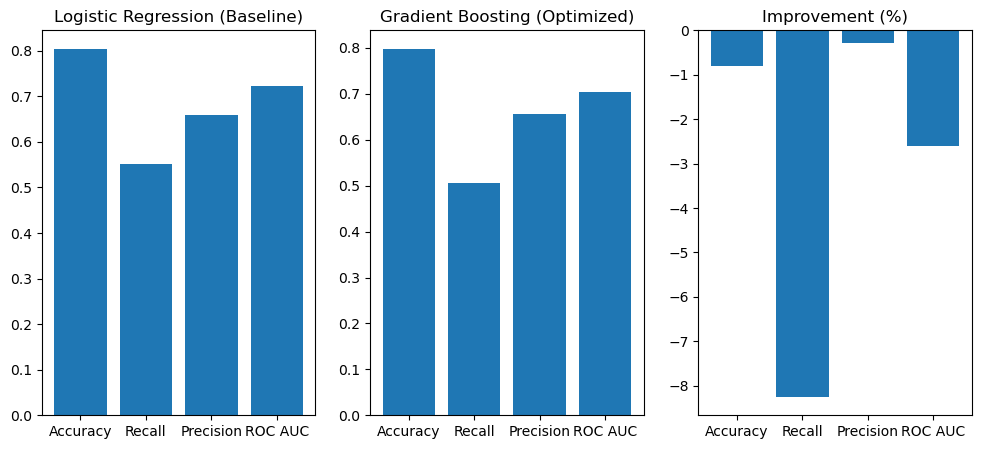

In [227]:
plt.subplots(1,3,figsize=(12,5))

for c, i in zip(results_df.drop(columns=['Metric']).columns, range(1,4)):
    plt.subplot(1,3,i)
    plt.bar(x=results_df['Metric'],height=results_df[c])
    plt.title(c)

## 7. Conclusions and Next Steps

### Summary
This notebook demonstrates a complete machine learning pipeline for predicting customer churn in telecommunications using customer demographics, service usage, and account features.

### Key Findings:
- **Baseline Model Performance**: The Logistic Regression baseline model achieved strong performance across all metrics, demonstrating good recall, precision, accuracy, and ROC AUC scores for churn prediction.

- **Complex Model Results**: Surprisingly, the Gradient Boosting model with Grid Search hyperparameter tuning did not improve upon the baseline performance. In fact, the optimized complex model showed worse results compared to the simple logistic regression approach.

- **Model Selection Decision**: Given that the baseline Logistic Regression model delivered satisfactory results with good performance metrics, it represents the optimal choice for this churn prediction task. The model offers several advantages:
  - **Computational Efficiency**: Significantly faster training and inference times compared to gradient boosting
  - **Interpretability**: Clear feature importance and coefficient interpretation for business stakeholders
  - **Satisfactory Performance**: Strong scores across recall, precision, accuracy, and ROC AUC metrics
  - **Cost-Effectiveness**: Lower computational resources required for deployment and maintenance

- **Occam's Razor Principle**: This case demonstrates that simpler models can often perform as well as or better than complex alternatives, especially when the dataset has clear linear relationships between features and the target variable.

### Potential Improvements:
1. **Feature Engineering**: Include temporal usage patterns, payment history, and customer lifecycle features
2. **Advanced Models**: Experiment with XGBoost, LightGBM, or ensemble methods
3. **Cross-Validation**: Implement k-fold cross-validation for more robust evaluation
4. **Class Imbalance**: Address potential churn imbalance with SMOTE or cost-sensitive learning
5. **Feature Importance**: Analyze which service and demographic factors most influence churn

### Production Considerations:
- Real-time churn scoring for proactive retention
- Integration with customer relationship management (CRM) systems
- Model monitoring and retraining pipeline for concept drift
- A/B testing framework for retention campaign effectiveness
- Scalability for processing large customer bases